# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=20,
        fold=2,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_11-58-43/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4967 | MulticlassF1Score=0.1543
Batch-30 : CrossEntropyLoss=2.4857 | MulticlassF1Score=0.2054
Batch-45 : CrossEntropyLoss=2.4612 | MulticlassF1Score=0.2200
Batch-60 : CrossEntropyLoss=2.4955 | MulticlassF1Score=0.2308
Batch-75 : CrossEntropyLoss=2.4652 | MulticlassF1Score=0.2363
Batch-90 : CrossEntropyLoss=2.4808 | MulticlassF1Score=0.2424
Batch-105: CrossEntropyLoss=2.4521 | MulticlassF1Score=0.2570
Batch-120: CrossEntropyLoss=2.4563 | MulticlassF1Score=0.2711
Batch-135: CrossEntropyLoss=2.4444 | MulticlassF1Score=0.2826
Batch-150: CrossEntropyLoss=2.4141 | MulticlassF1Score=0.2911
Batch-165: CrossEntropyLoss=2.4354 | MulticlassF1Score=0.2976
Batch-180: CrossEntropyLoss=2.4082 | MulticlassF1Score=0.3089
Batch-195: CrossEntropyLoss=2.3689 | MulticlassF1Score=0.3295
Batch-210: CrossEntropyLoss=2.3933 | MulticlassF1Score=0.3475
Batch-225: CrossEntropyLoss=2.3668 | MulticlassF1Score=0.3636
Batch-226: CrossEntropyLoss=2.3662 | MulticlassF1Score=0.3642

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3754 | MulticlassF1Score=0.5973
Batch-30 : CrossEntropyLoss=2.3473 | MulticlassF1Score=0.5964
Batch-45 : CrossEntropyLoss=2.3834 | MulticlassF1Score=0.5940
Batch-60 : CrossEntropyLoss=2.3684 | MulticlassF1Score=0.5937
Batch-63 : CrossEntropyLoss=2.3948 | MulticlassF1Score=0.5935

Training   : Mean CrossEntropyLoss = 2.4545 | Mean MulticlassF1Score = 0.2618
Validation : Mean CrossEntropyLoss = 2.3740 | Mean MulticlassF1Score = 0.5946

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3596 | MulticlassF1Score=0.5941
Batch-30 : CrossEntropyLoss=2.3569 | MulticlassF1Score=0.6274
Batch-45 : CrossEntropyLoss=2.3523 | MulticlassF1Score=0.6415
Batch-60 : CrossEntropyLoss=2.3623 | MulticlassF1Score=0.6502
Batch-75 : CrossEntropyLoss=2.3445 | MulticlassF1Score=0.6555
Batch-90 : CrossEntropyLoss=2.3339 | MulticlassF1Score=0.6583
Batch-105: CrossEntropyLoss=2.3249 | MulticlassF1Score=0.6613
Batch-120: CrossEntropyLoss=2.3456 | MulticlassF1Score=0.6664
Batch-135: CrossEntropyLoss=2.3413 | MulticlassF1Score=0.6724
Batch-150: CrossEntropyLoss=2.3372 | MulticlassF1Score=0.6768
Batch-165: CrossEntropyLoss=2.3233 | MulticlassF1Score=0.6817
Batch-180: CrossEntropyLoss=2.3439 | MulticlassF1Score=0.6834
Batch-195: CrossEntropyLoss=2.3423 | MulticlassF1Score=0.6866
Batch-210: CrossEntropyLoss=2.3308 | MulticlassF1Score=0.6892
Batch-225: CrossEntropyLoss=2.3329 | MulticlassF1Score=0.6913
Batch-226: CrossEntropyLoss=2.3385 | MulticlassF1Score=0.6913

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3409 | MulticlassF1Score=0.7245
Batch-30 : CrossEntropyLoss=2.3338 | MulticlassF1Score=0.7225
Batch-45 : CrossEntropyLoss=2.3481 | MulticlassF1Score=0.7243
Batch-60 : CrossEntropyLoss=2.3367 | MulticlassF1Score=0.7233
Batch-63 : CrossEntropyLoss=2.3497 | MulticlassF1Score=0.7226

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3445 | Mean MulticlassF1Score = 0.6600
Validation : Mean CrossEntropyLoss = 2.3342 | Mean MulticlassF1Score = 0.7238

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3406 | MulticlassF1Score=0.7251
Batch-30 : CrossEntropyLoss=2.3314 | MulticlassF1Score=0.7233
Batch-45 : CrossEntropyLoss=2.3520 | MulticlassF1Score=0.7241
Batch-60 : CrossEntropyLoss=2.3165 | MulticlassF1Score=0.7304
Batch-75 : CrossEntropyLoss=2.3258 | MulticlassF1Score=0.7381
Batch-90 : CrossEntropyLoss=2.3099 | MulticlassF1Score=0.7461
Batch-105: CrossEntropyLoss=2.3192 | MulticlassF1Score=0.7524
Batch-120: CrossEntropyLoss=2.3123 | MulticlassF1Score=0.7562
Batch-135: CrossEntropyLoss=2.3017 | MulticlassF1Score=0.7600
Batch-150: CrossEntropyLoss=2.3036 | MulticlassF1Score=0.7632
Batch-165: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.7657
Batch-180: CrossEntropyLoss=2.3209 | MulticlassF1Score=0.7682
Batch-195: CrossEntropyLoss=2.3128 | MulticlassF1Score=0.7695
Batch-210: CrossEntropyLoss=2.3094 | MulticlassF1Score=0.7715
Batch-225: CrossEntropyLoss=2.3153 | MulticlassF1Score=0.7727
Batch-226: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.7728

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7886
Batch-30 : CrossEntropyLoss=2.3110 | MulticlassF1Score=0.7912
Batch-45 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.7939
Batch-60 : CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7930
Batch-63 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.7926

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3187 | Mean MulticlassF1Score = 0.7498
Validation : Mean CrossEntropyLoss = 2.3121 | Mean MulticlassF1Score = 0.7888

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3096 | MulticlassF1Score=0.7968
Batch-30 : CrossEntropyLoss=2.3159 | MulticlassF1Score=0.7952
Batch-45 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.7955
Batch-60 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.7945
Batch-75 : CrossEntropyLoss=2.3053 | MulticlassF1Score=0.7954
Batch-90 : CrossEntropyLoss=2.3237 | MulticlassF1Score=0.7957
Batch-105: CrossEntropyLoss=2.3137 | MulticlassF1Score=0.7950
Batch-120: CrossEntropyLoss=2.3043 | MulticlassF1Score=0.7959
Batch-135: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.7957
Batch-150: CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7952
Batch-165: CrossEntropyLoss=2.3089 | MulticlassF1Score=0.7956
Batch-180: CrossEntropyLoss=2.3191 | MulticlassF1Score=0.7954
Batch-195: CrossEntropyLoss=2.3123 | MulticlassF1Score=0.7955
Batch-210: CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7957
Batch-225: CrossEntropyLoss=2.3179 | MulticlassF1Score=0.7959
Batch-226: CrossEntropyLoss=2.3059 | MulticlassF1Score=0.7959

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3162 | MulticlassF1Score=0.7861
Batch-30 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.7901
Batch-45 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.7932
Batch-60 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.7958
Batch-63 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.7957

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3111 | Mean MulticlassF1Score = 0.7959
Validation : Mean CrossEntropyLoss = 2.3110 | Mean MulticlassF1Score = 0.7906

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8033
Batch-30 : CrossEntropyLoss=2.3115 | MulticlassF1Score=0.8066
Batch-45 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8024
Batch-60 : CrossEntropyLoss=2.3209 | MulticlassF1Score=0.8007
Batch-75 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8019
Batch-90 : CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8025
Batch-105: CrossEntropyLoss=2.3094 | MulticlassF1Score=0.8023
Batch-120: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8033
Batch-135: CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8040
Batch-150: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8067
Batch-165: CrossEntropyLoss=2.3094 | MulticlassF1Score=0.8086
Batch-180: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8106
Batch-195: CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8121
Batch-210: CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8128
Batch-225: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8145
Batch-226: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8146

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8383
Batch-30 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8358
Batch-45 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8351
Batch-60 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8346
Batch-63 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8353

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3054 | Mean MulticlassF1Score = 0.8059
Validation : Mean CrossEntropyLoss = 2.2987 | Mean MulticlassF1Score = 0.8362

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8449
Batch-30 : CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8415
Batch-45 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8408
Batch-60 : CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8387
Batch-75 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8385
Batch-90 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8386
Batch-105: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8386
Batch-120: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8393
Batch-135: CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8391
Batch-150: CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8395
Batch-165: CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8391
Batch-180: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8392
Batch-195: CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8391
Batch-210: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8390
Batch-225: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8393
Batch-226: CrossEntropyLoss=2.3128 | MulticlassF1Score=0.8392

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8391
Batch-30 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8385
Batch-45 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8372
Batch-60 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8370
Batch-63 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8366

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2976 | Mean MulticlassF1Score = 0.8398
Validation : Mean CrossEntropyLoss = 2.2982 | Mean MulticlassF1Score = 0.8380

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8422
Batch-30 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8432
Batch-45 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8403
Batch-60 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8411
Batch-75 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8404
Batch-90 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8410
Batch-105: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8407
Batch-120: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8410
Batch-135: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8404
Batch-150: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8401
Batch-165: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8404
Batch-180: CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8406
Batch-195: CrossEntropyLoss=2.3083 | MulticlassF1Score=0.8404
Batch-210: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8410
Batch-225: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8411
Batch-226: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8410

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8355
Batch-30 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8339
Batch-45 : CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8359
Batch-60 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8360
Batch-63 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8364

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2969 | Mean MulticlassF1Score = 0.8413
Validation : Mean CrossEntropyLoss = 2.2981 | Mean MulticlassF1Score = 0.8358

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8402
Batch-30 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8405
Batch-45 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8404
Batch-60 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8434
Batch-75 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8433
Batch-90 : CrossEntropyLoss=2.3083 | MulticlassF1Score=0.8426
Batch-105: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8429
Batch-120: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8430
Batch-135: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8428
Batch-150: CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8424
Batch-165: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8429
Batch-180: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8426
Batch-195: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8427
Batch-210: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8440
Batch-225: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8459
Batch-226: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8460

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8640
Batch-30 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8642
Batch-45 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8619
Batch-60 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8623
Batch-63 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8626

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2954 | Mean MulticlassF1Score = 0.8428
Validation : Mean CrossEntropyLoss = 2.2905 | Mean MulticlassF1Score = 0.8630

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8629
Batch-30 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8627
Batch-45 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8654
Batch-60 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8657
Batch-75 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8664
Batch-90 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8677
Batch-105: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8684
Batch-120: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8689
Batch-135: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8696
Batch-150: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8696
Batch-165: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8696
Batch-180: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8694
Batch-195: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8700
Batch-210: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8706
Batch-225: CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8703
Batch-226: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8631
Batch-30 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8638
Batch-45 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8664
Batch-60 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8658
Batch-63 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8661

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2881 | Mean MulticlassF1Score = 0.8673
Validation : Mean CrossEntropyLoss = 2.2892 | Mean MulticlassF1Score = 0.8637

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8719
Batch-30 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8709
Batch-45 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8722
Batch-60 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8728
Batch-75 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8720
Batch-90 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8718
Batch-105: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8720
Batch-120: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8725
Batch-135: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8730
Batch-150: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8736
Batch-165: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8732
Batch-180: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8736
Batch-195: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8738
Batch-210: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8741
Batch-225: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8741
Batch-226: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8742

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8723
Batch-30 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8660
Batch-45 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8659
Batch-60 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8672
Batch-63 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8674

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2868 | Mean MulticlassF1Score = 0.8725
Validation : Mean CrossEntropyLoss = 2.2886 | Mean MulticlassF1Score = 0.8686

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8780
Batch-30 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8746
Batch-45 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8761
Batch-60 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8779
Batch-75 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8773
Batch-90 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8769
Batch-105: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8766
Batch-120: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8772
Batch-135: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8770
Batch-150: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8773
Batch-165: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8771
Batch-180: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8768
Batch-195: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8767
Batch-210: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8769
Batch-225: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8766
Batch-226: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8765

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8647
Batch-30 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8678
Batch-45 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8682
Batch-60 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8681
Batch-63 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8688

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2859 | Mean MulticlassF1Score = 0.8765
Validation : Mean CrossEntropyLoss = 2.2882 | Mean MulticlassF1Score = 0.8668

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8737
Batch-30 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8779
Batch-45 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8787
Batch-60 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8785
Batch-75 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8787
Batch-90 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8791
Batch-105: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8790
Batch-120: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8788
Batch-135: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8783
Batch-150: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8786
Batch-165: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8785
Batch-180: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.8787
Batch-195: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8786
Batch-210: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8785
Batch-225: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8784
Batch-226: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8784

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8707
Batch-30 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8684
Batch-45 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8690
Batch-60 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8694
Batch-63 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8692

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2853 | Mean MulticlassF1Score = 0.8781
Validation : Mean CrossEntropyLoss = 2.2881 | Mean MulticlassF1Score = 0.8687

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8802
Batch-30 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8811
Batch-45 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8798
Batch-60 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8805
Batch-75 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8801
Batch-90 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8799
Batch-105: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8805
Batch-120: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8805
Batch-135: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8801
Batch-150: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8798
Batch-165: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8799
Batch-180: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8799
Batch-195: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8797
Batch-210: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8795
Batch-225: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8798
Batch-226: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8798

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8736
Batch-30 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8706
Batch-45 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8692
Batch-60 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8701
Batch-63 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8702

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2849 | Mean MulticlassF1Score = 0.8801
Validation : Mean CrossEntropyLoss = 2.2877 | Mean MulticlassF1Score = 0.8710

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8819
Batch-30 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8813
Batch-45 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8832
Batch-60 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8835
Batch-75 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8824
Batch-90 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8815
Batch-105: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8816
Batch-120: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8813
Batch-135: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8811
Batch-150: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8814
Batch-165: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8818
Batch-180: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8821
Batch-195: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8816
Batch-210: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8817
Batch-225: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8812
Batch-226: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8812

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8629
Batch-30 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8682
Batch-45 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8684
Batch-60 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8690
Batch-63 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8690

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2844 | Mean MulticlassF1Score = 0.8815
Validation : Mean CrossEntropyLoss = 2.2881 | Mean MulticlassF1Score = 0.8667

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8781
Batch-30 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8796
Batch-45 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8804
Batch-60 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8807
Batch-75 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8803
Batch-90 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8794
Batch-105: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8805
Batch-120: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8811
Batch-135: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8818
Batch-150: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8817
Batch-165: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8816
Batch-180: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8816
Batch-195: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8819
Batch-210: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8817
Batch-225: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8818
Batch-226: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.8819

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8714
Batch-30 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8738
Batch-45 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8736
Batch-60 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8721
Batch-63 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8716

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2841 | Mean MulticlassF1Score = 0.8807
Validation : Mean CrossEntropyLoss = 2.2873 | Mean MulticlassF1Score = 0.8723

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8878
Batch-30 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8844
Batch-45 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8834
Batch-60 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8845
Batch-75 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8841
Batch-90 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8837
Batch-105: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8837
Batch-120: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8842
Batch-135: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8841
Batch-150: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.8839
Batch-165: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8838
Batch-180: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8836
Batch-195: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8837
Batch-210: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8835
Batch-225: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8836
Batch-226: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8837

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8711
Batch-30 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8723
Batch-45 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8708
Batch-60 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8717
Batch-63 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8718

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2835 | Mean MulticlassF1Score = 0.8841
Validation : Mean CrossEntropyLoss = 2.2872 | Mean MulticlassF1Score = 0.8723

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8904
Batch-30 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8866
Batch-45 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8861
Batch-60 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8864
Batch-75 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8878
Batch-90 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8902
Batch-105: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8922
Batch-120: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8936
Batch-135: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8949
Batch-150: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.8959
Batch-165: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8965
Batch-180: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.8975
Batch-195: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.8979
Batch-210: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8985
Batch-225: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8988
Batch-226: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.8989

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8933
Batch-30 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8934
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8926
Batch-60 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8936
Batch-63 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8932

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2791 | Mean MulticlassF1Score = 0.8927
Validation : Mean CrossEntropyLoss = 2.2808 | Mean MulticlassF1Score = 0.8937

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9078
Batch-30 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9097
Batch-45 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.9091
Batch-60 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9090
Batch-75 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9089
Batch-90 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9086
Batch-105: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9089
Batch-120: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9089
Batch-135: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9089
Batch-150: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9087
Batch-165: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9086
Batch-180: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9083
Batch-195: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9079
Batch-210: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9075
Batch-225: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9076
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9076

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8902
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.8960
Batch-45 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8941
Batch-60 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8942
Batch-63 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8944

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2764 | Mean MulticlassF1Score = 0.9081
Validation : Mean CrossEntropyLoss = 2.2804 | Mean MulticlassF1Score = 0.8933

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9134
Batch-30 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9119
Batch-45 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9117
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9120
Batch-75 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9116
Batch-90 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9112
Batch-105: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9116
Batch-120: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9110
Batch-135: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9110
Batch-150: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9108
Batch-165: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9105
Batch-180: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9100
Batch-195: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9098
Batch-210: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9094
Batch-225: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9093
Batch-226: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9092

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8970
Batch-30 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8960
Batch-45 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8958
Batch-60 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8956
Batch-63 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8955

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2758 | Mean MulticlassF1Score = 0.9114
Validation : Mean CrossEntropyLoss = 2.2801 | Mean MulticlassF1Score = 0.8967

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9165
Batch-30 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9166
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9152
Batch-60 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9137
Batch-75 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9122
Batch-90 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9124
Batch-105: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9115
Batch-120: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9108
Batch-135: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9105
Batch-150: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9106
Batch-165: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9107
Batch-180: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9108
Batch-195: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9107
Batch-210: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9107
Batch-225: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9107
Batch-226: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9108

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.8944
Batch-30 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8959
Batch-45 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8962
Batch-60 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8955
Batch-63 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8955

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2753 | Mean MulticlassF1Score = 0.9122
Validation : Mean CrossEntropyLoss = 2.2800 | Mean MulticlassF1Score = 0.8949

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9142
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9118
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9122
Batch-60 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9113
Batch-75 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9113
Batch-90 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9104
Batch-105: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9107
Batch-120: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9111
Batch-135: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9108
Batch-150: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9113
Batch-165: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9116
Batch-180: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9113
Batch-195: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9117
Batch-210: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9115
Batch-225: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9115
Batch-226: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9115

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8976
Batch-30 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8962
Batch-45 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8959
Batch-60 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8959
Batch-63 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8958

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2750 | Mean MulticlassF1Score = 0.9116
Validation : Mean CrossEntropyLoss = 2.2799 | Mean MulticlassF1Score = 0.8976

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9094
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9105
Batch-45 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9110
Batch-60 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9101
Batch-75 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9118
Batch-90 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9125
Batch-105: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.9128
Batch-120: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9130
Batch-135: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9111
Batch-150: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9104
Batch-165: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9099
Batch-180: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9096
Batch-195: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9093
Batch-210: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9090
Batch-225: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9087
Batch-226: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9088

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8958
Batch-30 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8950
Batch-45 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8941
Batch-60 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8945
Batch-63 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8947

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2763 | Mean MulticlassF1Score = 0.9105
Validation : Mean CrossEntropyLoss = 2.2803 | Mean MulticlassF1Score = 0.8953
Patience = 1/50❗

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9139
Batch-30 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9117
Batch-45 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.9118
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9114
Batch-75 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9109
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9115
Batch-105: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9113
Batch-120: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9112
Batch-135: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.9112
Batch-150: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9112
Batch-165: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9111
Batch-180: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9109
Batch-195: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9107
Batch-210: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9104
Batch-225: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9105
Batch-226: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9105

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8922
Batch-30 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8932
Batch-45 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8945
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8955
Batch-63 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8958

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2754 | Mean MulticlassF1Score = 0.9112
Validation : Mean CrossEntropyLoss = 2.2798 | Mean MulticlassF1Score = 0.8936

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9164
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9135
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9170
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9216
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9233
Batch-90 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9248
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9262
Batch-120: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9279
Batch-135: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9286
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9295
Batch-165: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9300
Batch-180: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9307
Batch-195: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9315
Batch-210: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9318
Batch-225: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9323
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9323

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9258
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9249
Batch-45 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9239
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9225
Batch-63 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9228

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2687 | Mean MulticlassF1Score = 0.9253
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9248

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9396
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9391
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9404
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9399
Batch-75 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9409
Batch-90 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9411
Batch-105: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9414
Batch-120: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9413
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9409
Batch-150: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9408
Batch-165: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9411
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9413
Batch-195: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9414
Batch-210: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9412
Batch-225: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9411
Batch-226: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9411

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9239
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9238
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9233
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9243

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9409
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9244

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9443
Batch-30 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9434
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9429
Batch-75 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9434
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9433
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9431
Batch-120: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9432
Batch-135: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9433
Batch-150: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9431
Batch-165: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9429
Batch-180: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9429
Batch-195: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9430
Batch-210: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9429
Batch-225: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9427
Batch-226: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9427

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9263
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9261
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9255
Batch-63 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9254

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9429
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9251

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9402
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9420
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9424
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9430
Batch-75 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9426
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9433
Batch-105: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9436
Batch-120: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9435
Batch-135: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9440
Batch-150: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9439
Batch-165: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9438
Batch-180: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9435
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9435
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9436
Batch-225: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9435
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9435

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9248
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9267
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9251
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9249
Batch-63 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9248

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9431
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9260

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9435
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9454
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9448
Batch-75 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9447
Batch-90 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9445
Batch-105: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9444
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9439
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9444
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9441
Batch-165: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9440
Batch-180: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9441
Batch-195: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9441
Batch-210: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9441
Batch-225: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9441
Batch-226: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9441

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9293
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9294
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9273
Batch-60 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9264
Batch-63 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9262

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9444
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9276

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9454
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9455
Batch-75 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9445
Batch-90 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9445
Batch-105: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9443
Batch-120: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9448
Batch-135: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9449
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9449
Batch-165: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9449
Batch-180: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9447
Batch-195: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9446
Batch-210: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9446
Batch-225: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9446
Batch-226: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9446

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9294
Batch-30 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9273
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9276
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9266
Batch-63 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9260

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9448
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9289

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9449
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9449
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9440
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9439
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9446
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9450
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9452
Batch-120: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9452
Batch-135: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9451
Batch-150: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9450
Batch-165: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9448
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9451
Batch-195: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9450
Batch-210: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9450
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9450
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9450

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9227
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9242
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9260
Batch-63 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9263

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9447
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9233

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9466
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9459
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9458
Batch-90 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9452
Batch-105: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9460
Batch-120: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9451
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9450
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9450
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9450
Batch-180: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9448
Batch-195: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9448
Batch-210: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9448
Batch-225: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9449
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9449

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9255
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9271
Batch-45 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9255
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9256
Batch-63 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9256

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9252
Patience = 2/50❗

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9460
Batch-75 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9456
Batch-90 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9458
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9458
Batch-120: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9456
Batch-135: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9455
Batch-150: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9452
Batch-165: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9451
Batch-180: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9452
Batch-195: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9454
Batch-210: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9450
Batch-225: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9447
Batch-226: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9447

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9246
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9241
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9251
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9251
Batch-63 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9248

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9458
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9252
Patience = 3/50❗

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9457
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9452
Batch-75 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9444
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9446
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9449
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9450
Batch-135: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9452
Batch-150: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9451
Batch-165: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9446
Batch-180: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9445
Batch-195: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9445
Batch-210: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9443
Batch-225: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9444
Batch-226: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9444

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9243
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9253
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9255
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9258

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9451
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9251
Patience = 4/50❗

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9465
Batch-75 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9469
Batch-90 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9465
Batch-105: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9467
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9461
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9464
Batch-150: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9464
Batch-165: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9463
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9461
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9463
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9462
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9462
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9462

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9265
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9255
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9267
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9274
Batch-63 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9272

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9465
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9273

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9465
Batch-75 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9462
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9465
Batch-105: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9468
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9466
Batch-135: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9467
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9465
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9469
Batch-180: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9470
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9474
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9474
Batch-225: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9470
Batch-226: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9470

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9295
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9293
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9285
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9278
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9279

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9467
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9285

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9514
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9512
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9498
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9492
Batch-75 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9496
Batch-90 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9497
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9492
Batch-120: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9489
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9490
Batch-150: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9493
Batch-165: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9491
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9491
Batch-195: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9490
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9489
Batch-225: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9489
Batch-226: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9488

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9286
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9301
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9291
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9288
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9290

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9496
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9296

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9482
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9497
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9493
Batch-75 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9495
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9493
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9493
Batch-120: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9492
Batch-135: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9490
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9493
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9495
Batch-180: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9493
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9496
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9497
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9497
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9497

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9283
Batch-30 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.9257
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9278
Batch-60 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9283
Batch-63 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9282

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9491
Validation : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9279

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9508
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9509
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9517
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9519
Batch-75 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9518
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9508
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9504
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9503
Batch-135: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9500
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9503
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9501
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9500
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9500
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9500
Batch-225: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9500
Batch-226: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9500

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9317
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9304
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9306
Batch-60 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9301
Batch-63 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9298

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2629 | Mean MulticlassF1Score = 0.9508
Validation : Mean CrossEntropyLoss = 2.2693 | Mean MulticlassF1Score = 0.9306

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9511
Batch-30 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9510
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9498
Batch-75 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9503
Batch-90 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9504
Batch-105: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9509
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9507
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9510
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9513
Batch-165: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9515
Batch-180: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9513
Batch-195: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9511
Batch-210: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9504
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9503
Batch-226: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9503

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9320
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9292
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9290
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9292
Batch-63 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9291

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2628 | Mean MulticlassF1Score = 0.9508
Validation : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9294

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9526
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9513
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9526
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9517
Batch-75 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9509
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9506
Batch-105: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9509
Batch-120: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9508
Batch-135: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9503
Batch-150: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9506
Batch-165: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9505
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9506
Batch-195: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9504
Batch-210: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9503
Batch-225: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9503
Batch-226: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9503

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9280
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9273
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9285
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9293
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9294

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2628 | Mean MulticlassF1Score = 0.9512
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9283
Patience = 5/50❗

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9493
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9495
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9506
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9508
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9505
Batch-90 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9504
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9496
Batch-120: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9497
Batch-135: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9497
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9495
Batch-165: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9495
Batch-180: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9496
Batch-195: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9496
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9497
Batch-225: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9495
Batch-226: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9495

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9272
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9304
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9305
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9299
Batch-63 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9302

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9501
Validation : Mean CrossEntropyLoss = 2.2691 | Mean MulticlassF1Score = 0.9288
Patience = 6/50❗

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9536
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9529
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9526
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9525
Batch-75 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9513
Batch-90 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9507
Batch-105: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9507
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9504
Batch-135: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9505
Batch-150: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9504
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9504
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9503
Batch-195: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9503
Batch-210: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9504
Batch-225: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9505
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9506

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9289
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9292
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9292
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9294
Batch-63 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9293

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2627 | Mean MulticlassF1Score = 0.9511
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9293

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9504
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9507
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9503
Batch-75 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9505
Batch-90 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9506
Batch-105: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9501
Batch-120: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9502
Batch-135: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9501
Batch-150: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9503
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9509
Batch-180: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9511
Batch-195: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9510
Batch-210: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9511
Batch-225: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9511
Batch-226: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9510

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9331
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9305
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9303
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9304
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9303

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2626 | Mean MulticlassF1Score = 0.9502
Validation : Mean CrossEntropyLoss = 2.2691 | Mean MulticlassF1Score = 0.9305

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9568
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9560
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9539
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9533
Batch-75 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9525
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9525
Batch-105: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9521
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9521
Batch-135: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9520
Batch-150: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9519
Batch-165: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9520
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9518
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9515
Batch-210: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9515
Batch-225: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9517
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9516

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9318
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9308
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9302
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9305
Batch-63 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.9301

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2624 | Mean MulticlassF1Score = 0.9530
Validation : Mean CrossEntropyLoss = 2.2691 | Mean MulticlassF1Score = 0.9303

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9519
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9508
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9507
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9509
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9506
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9507
Batch-120: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9509
Batch-135: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9512
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9512
Batch-165: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9515
Batch-180: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9513
Batch-195: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9517
Batch-210: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9516
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9517
Batch-226: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9518

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9297
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9296
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9301
Batch-60 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9305
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9309

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2623 | Mean MulticlassF1Score = 0.9512
Validation : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9300

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9531
Batch-30 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9531
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9519
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9518
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9523
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9521
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9522
Batch-120: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9519
Batch-135: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9515
Batch-150: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9514
Batch-165: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9515
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9518
Batch-195: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9516
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9518
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9519
Batch-226: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9519

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9334
Batch-30 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9302
Batch-45 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9307
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9307
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9305

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2622 | Mean MulticlassF1Score = 0.9519
Validation : Mean CrossEntropyLoss = 2.2690 | Mean MulticlassF1Score = 0.9309

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9498
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9525
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9532
Batch-60 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9532
Batch-75 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9532
Batch-90 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9529
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9531
Batch-120: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9526
Batch-135: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9527
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9525
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9526
Batch-180: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9525
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9525
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9522
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9521
Batch-226: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9521

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9327
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9316
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9303
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9299
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9303

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2622 | Mean MulticlassF1Score = 0.9522
Validation : Mean CrossEntropyLoss = 2.2690 | Mean MulticlassF1Score = 0.9312

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9529
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9525
Batch-45 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9521
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9522
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9525
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9532
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9523
Batch-120: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9524
Batch-135: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9522
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9521
Batch-165: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9522
Batch-180: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9521
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9522
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9522
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9520
Batch-226: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9520

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9298
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9324
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9318
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9306
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9303

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2623 | Mean MulticlassF1Score = 0.9521
Validation : Mean CrossEntropyLoss = 2.2690 | Mean MulticlassF1Score = 0.9323
Patience = 7/50❗

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9532
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9537
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9539
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9528
Batch-75 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9527
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9530
Batch-105: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9532
Batch-120: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9530
Batch-135: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9526
Batch-150: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9527
Batch-165: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9526
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9524
Batch-195: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9526
Batch-210: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9523
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9522
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9523

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9339
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9346
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9326
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9311
Batch-63 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9304

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2622 | Mean MulticlassF1Score = 0.9530
Validation : Mean CrossEntropyLoss = 2.2692 | Mean MulticlassF1Score = 0.9340

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9500
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9507
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9512
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9518
Batch-90 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9524
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9522
Batch-120: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9521
Batch-135: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9523
Batch-150: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9523
Batch-165: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9525
Batch-180: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9525
Batch-195: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9525
Batch-210: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9523
Batch-225: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9523
Batch-226: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9523

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9234
Batch-30 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9278
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9291
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9307
Batch-63 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9308

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2621 | Mean MulticlassF1Score = 0.9515
Validation : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9275

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2621
Best CrossEntropyLoss training    : 2.2689
Best MulticlassF1Score validation : 0.9515
Best MulticlassF1Score validation : 0.9275
Training duration                 : 2.6829 minutes.
Training date                     : 2022-10-19 14:33:59.526451+08:00


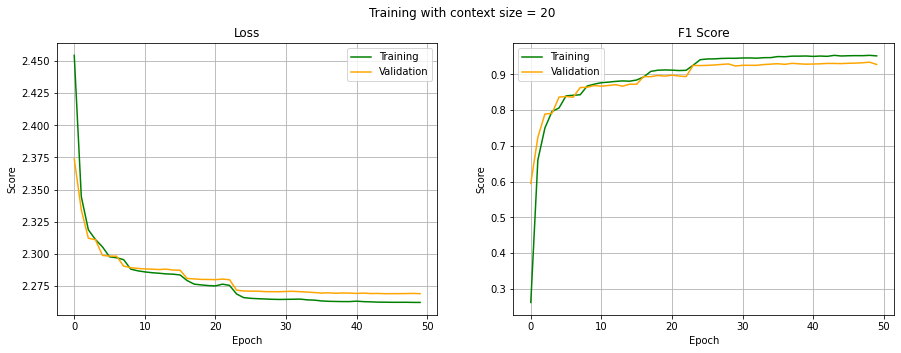

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9529, device='cuda:0'),
 tensor(0.9308, device='cuda:0'),
 tensor(0.9310, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9529, device='cuda:0'),
 tensor(0.9308, device='cuda:0'),
 tensor(0.9310, device='cuda:0'))

## Heatmap

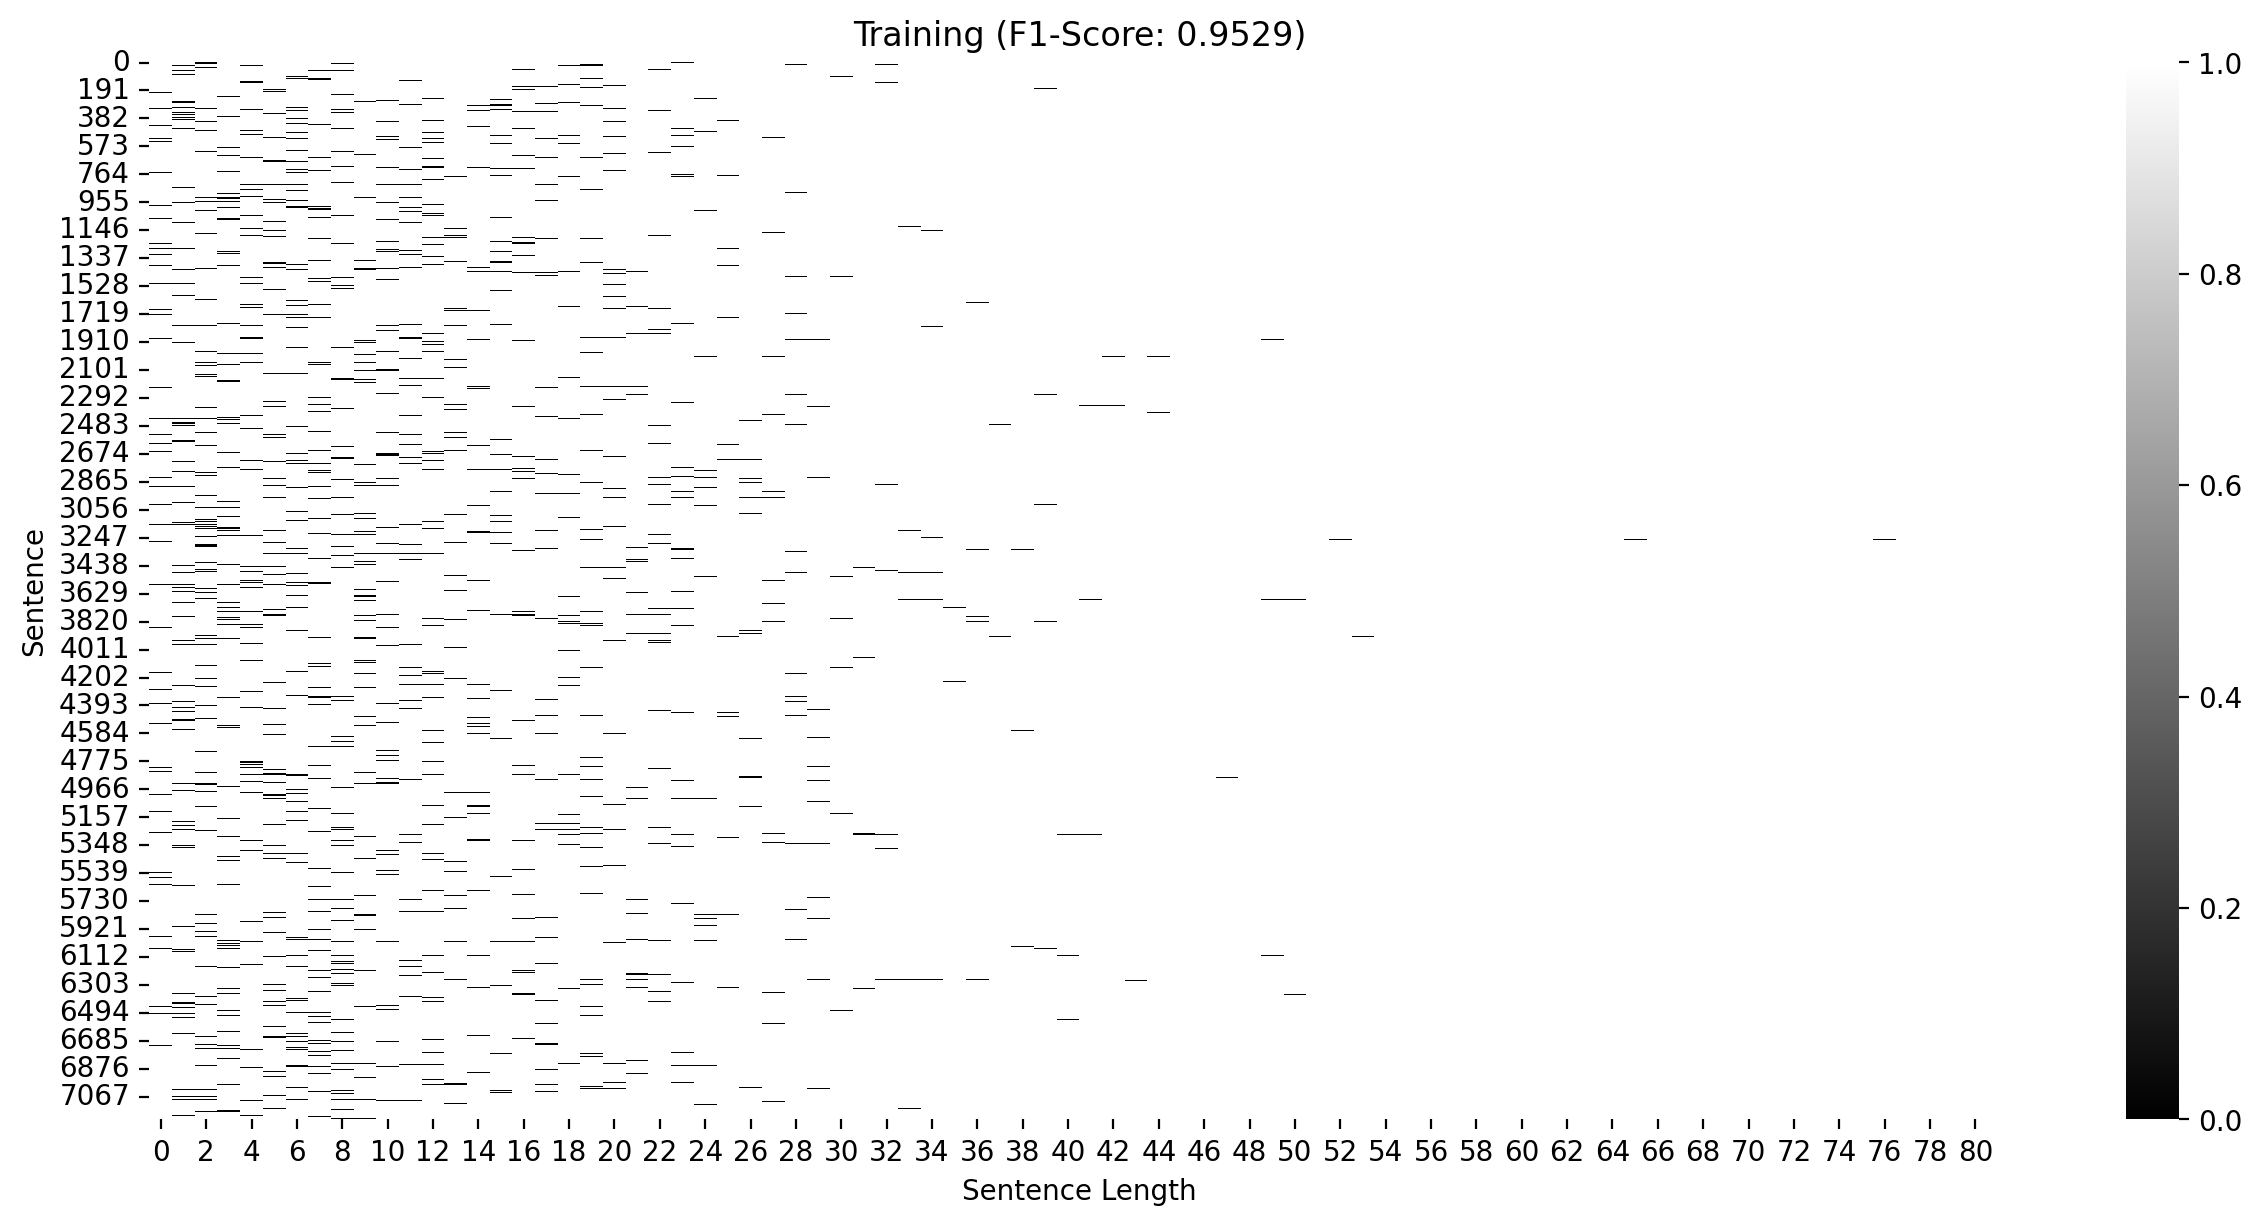

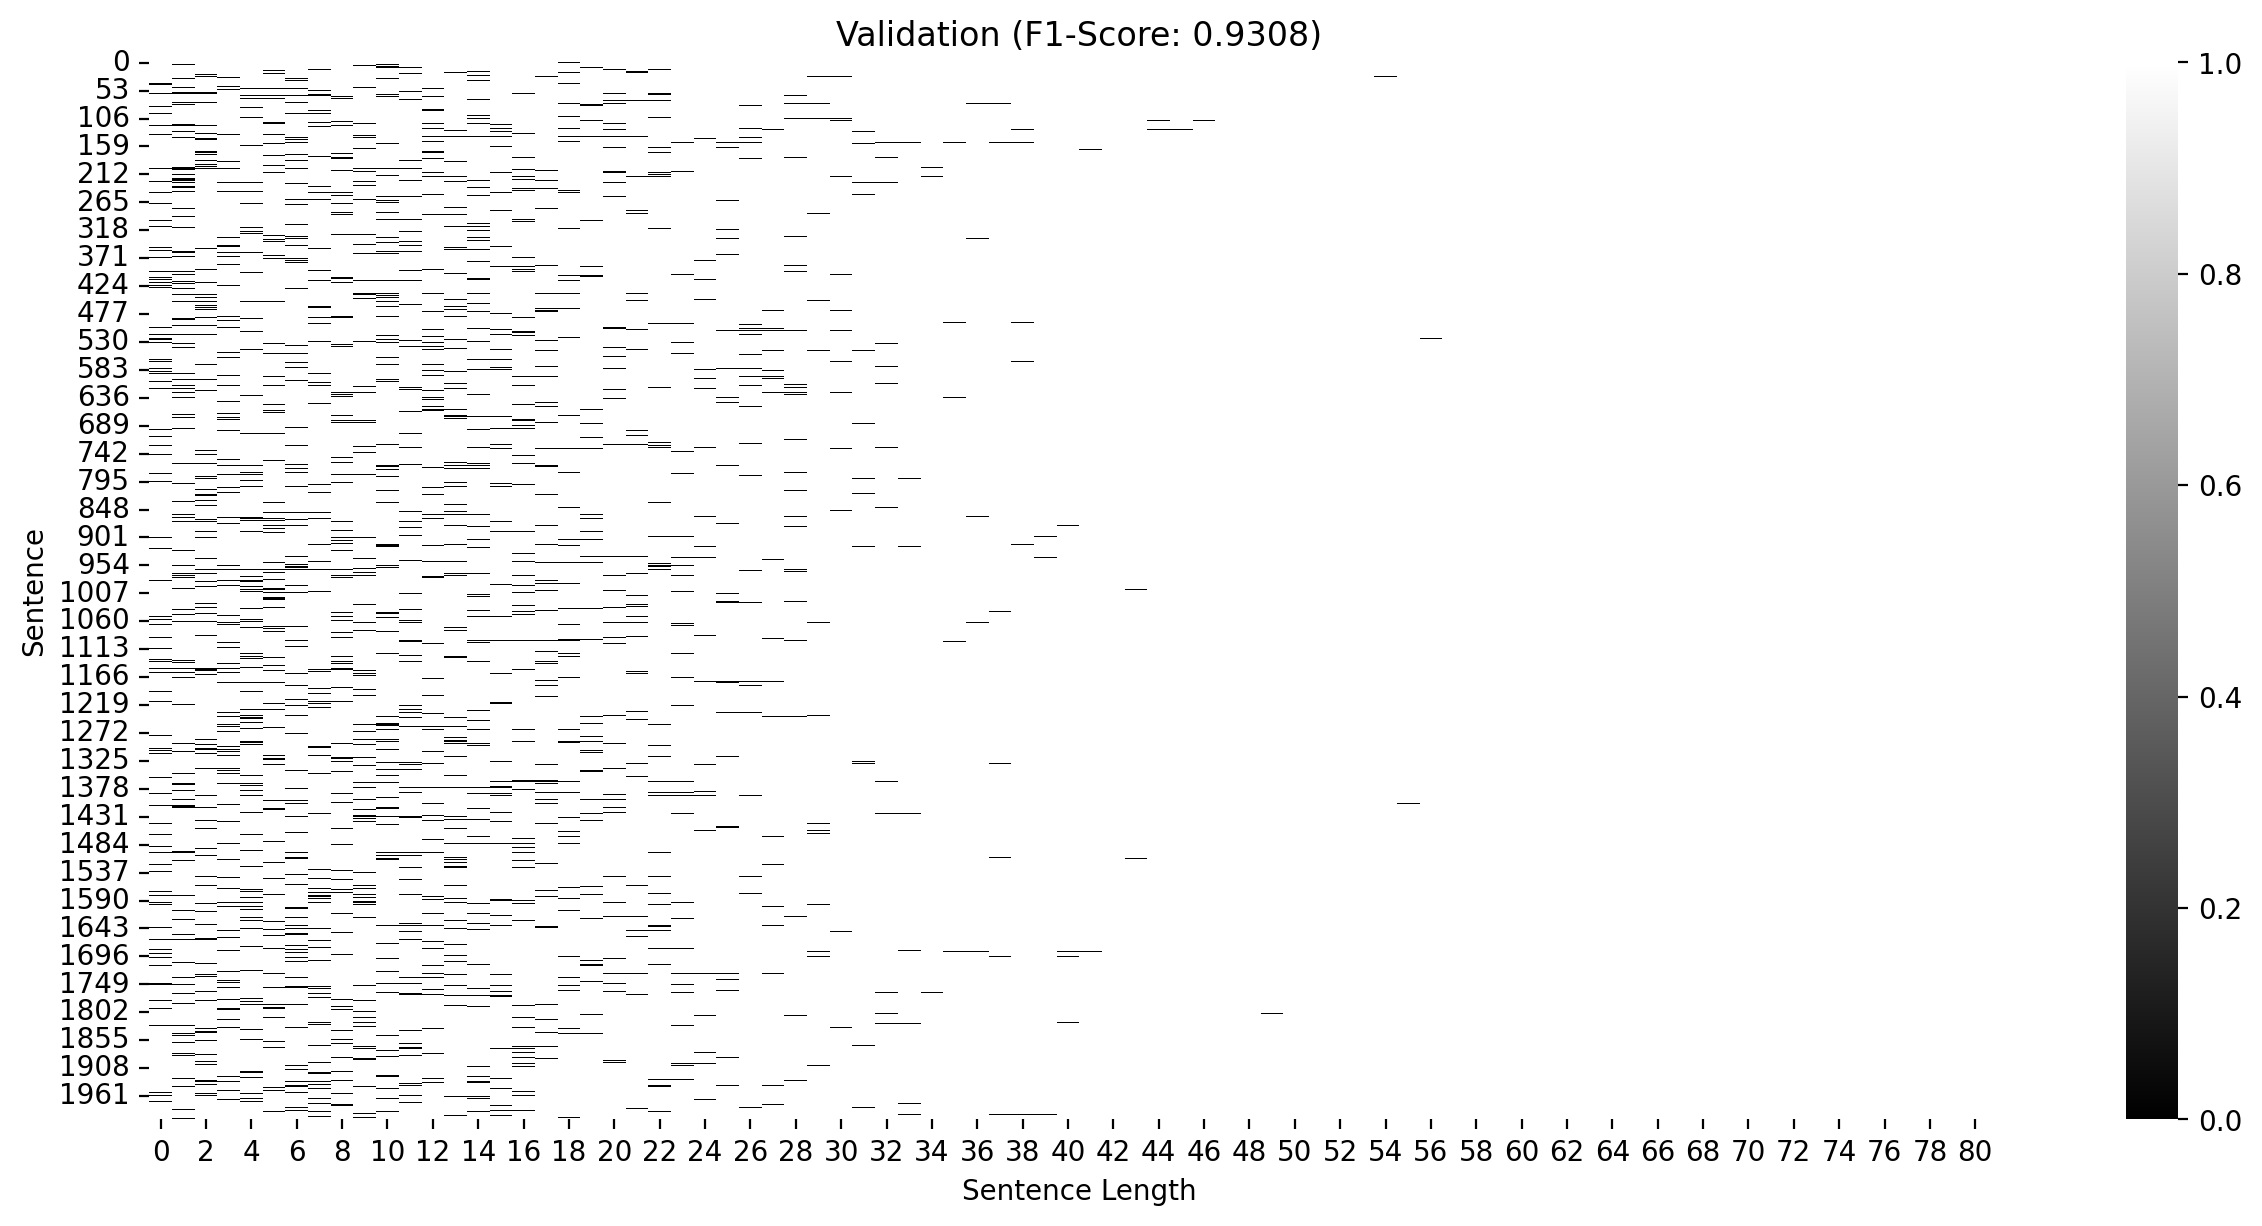

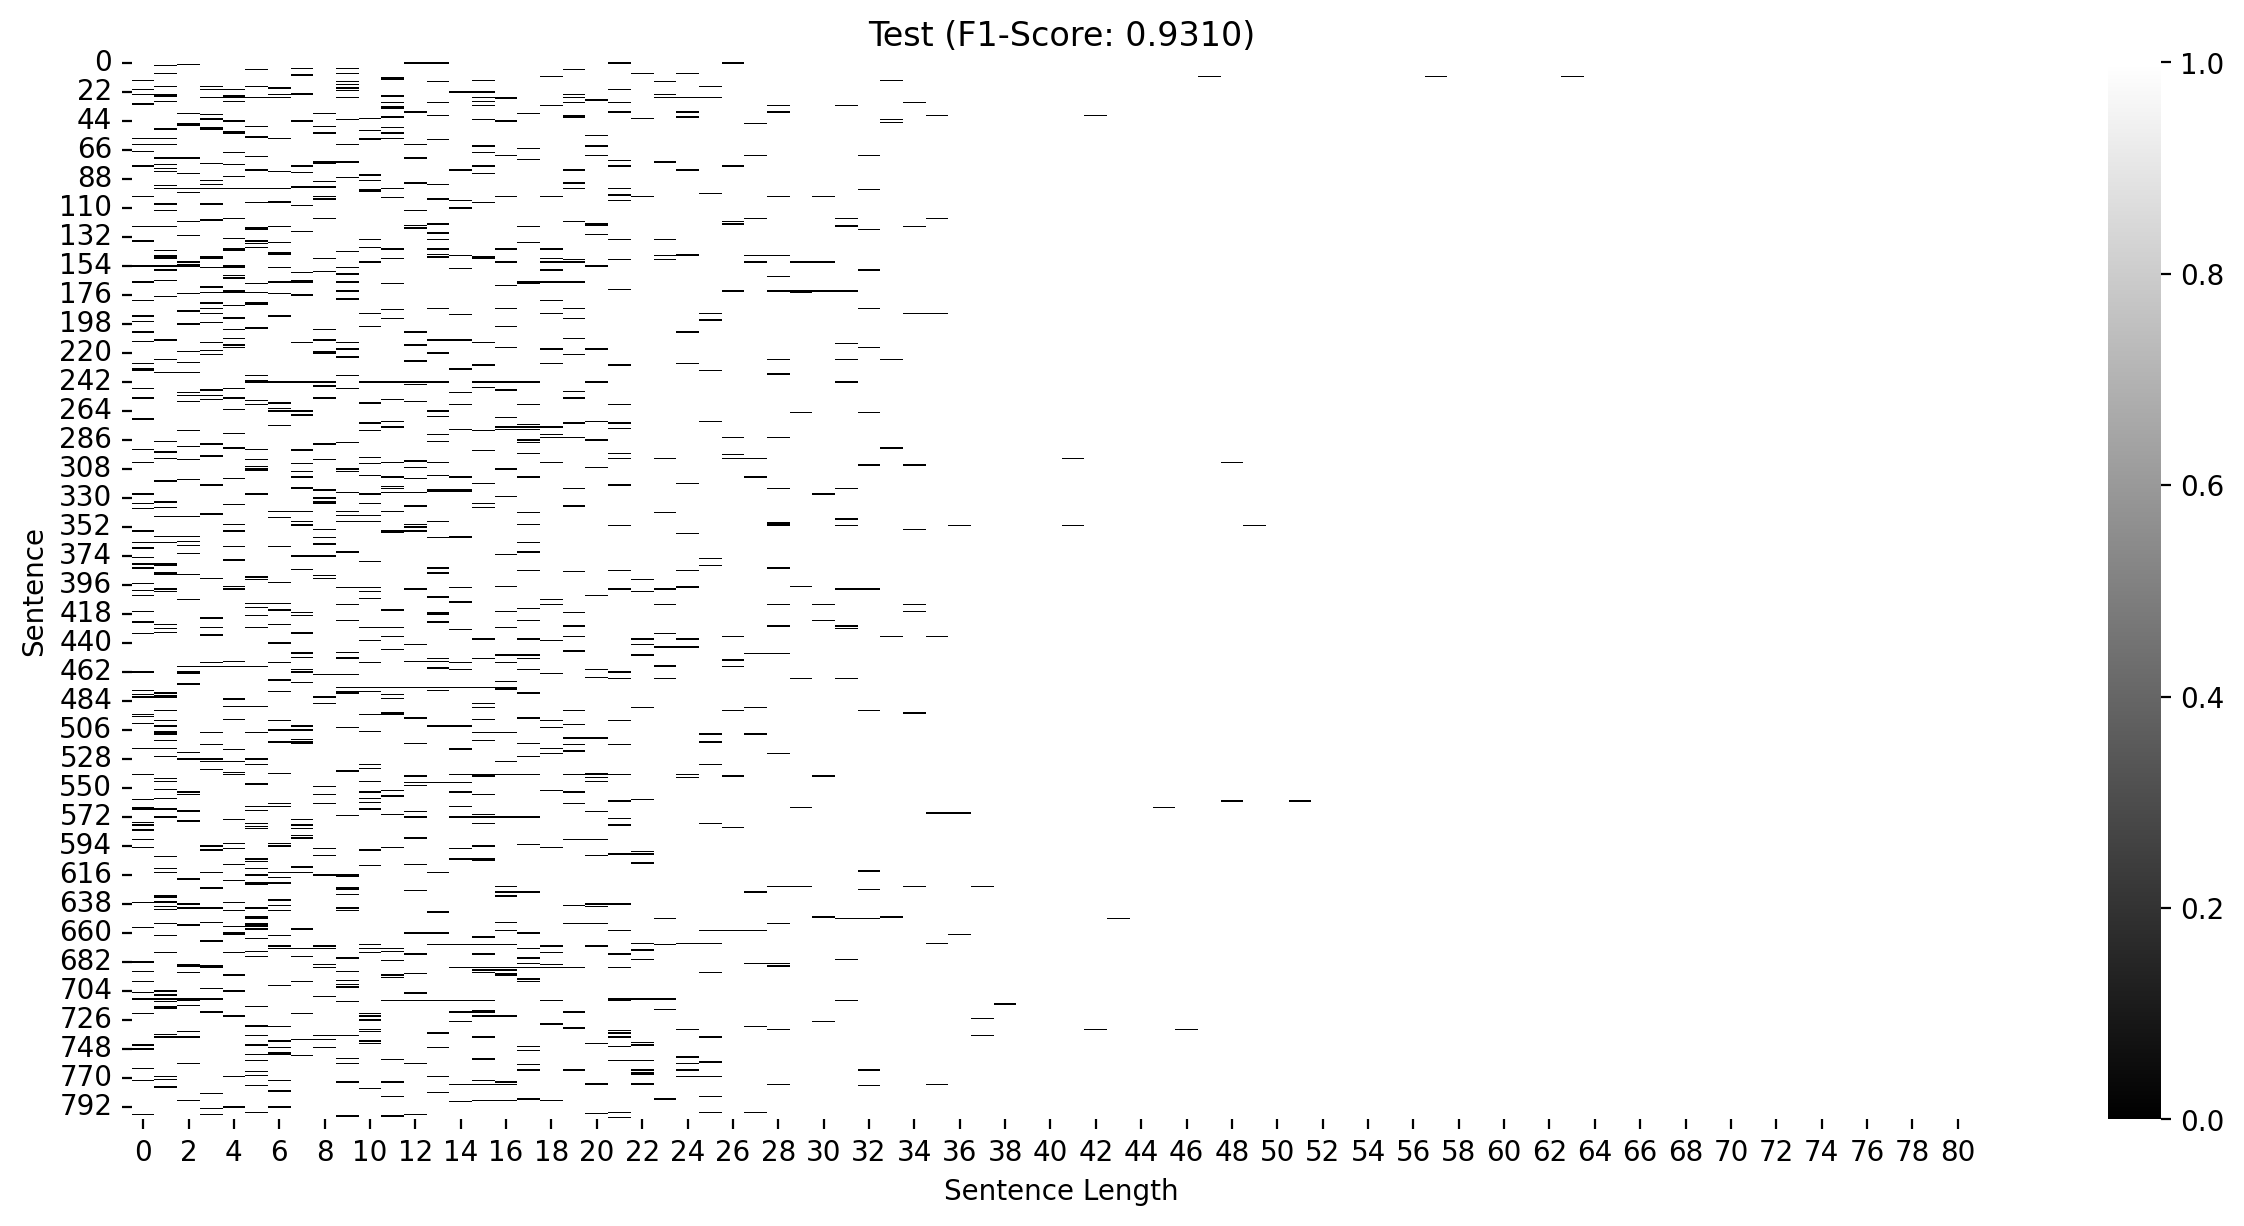

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 168 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


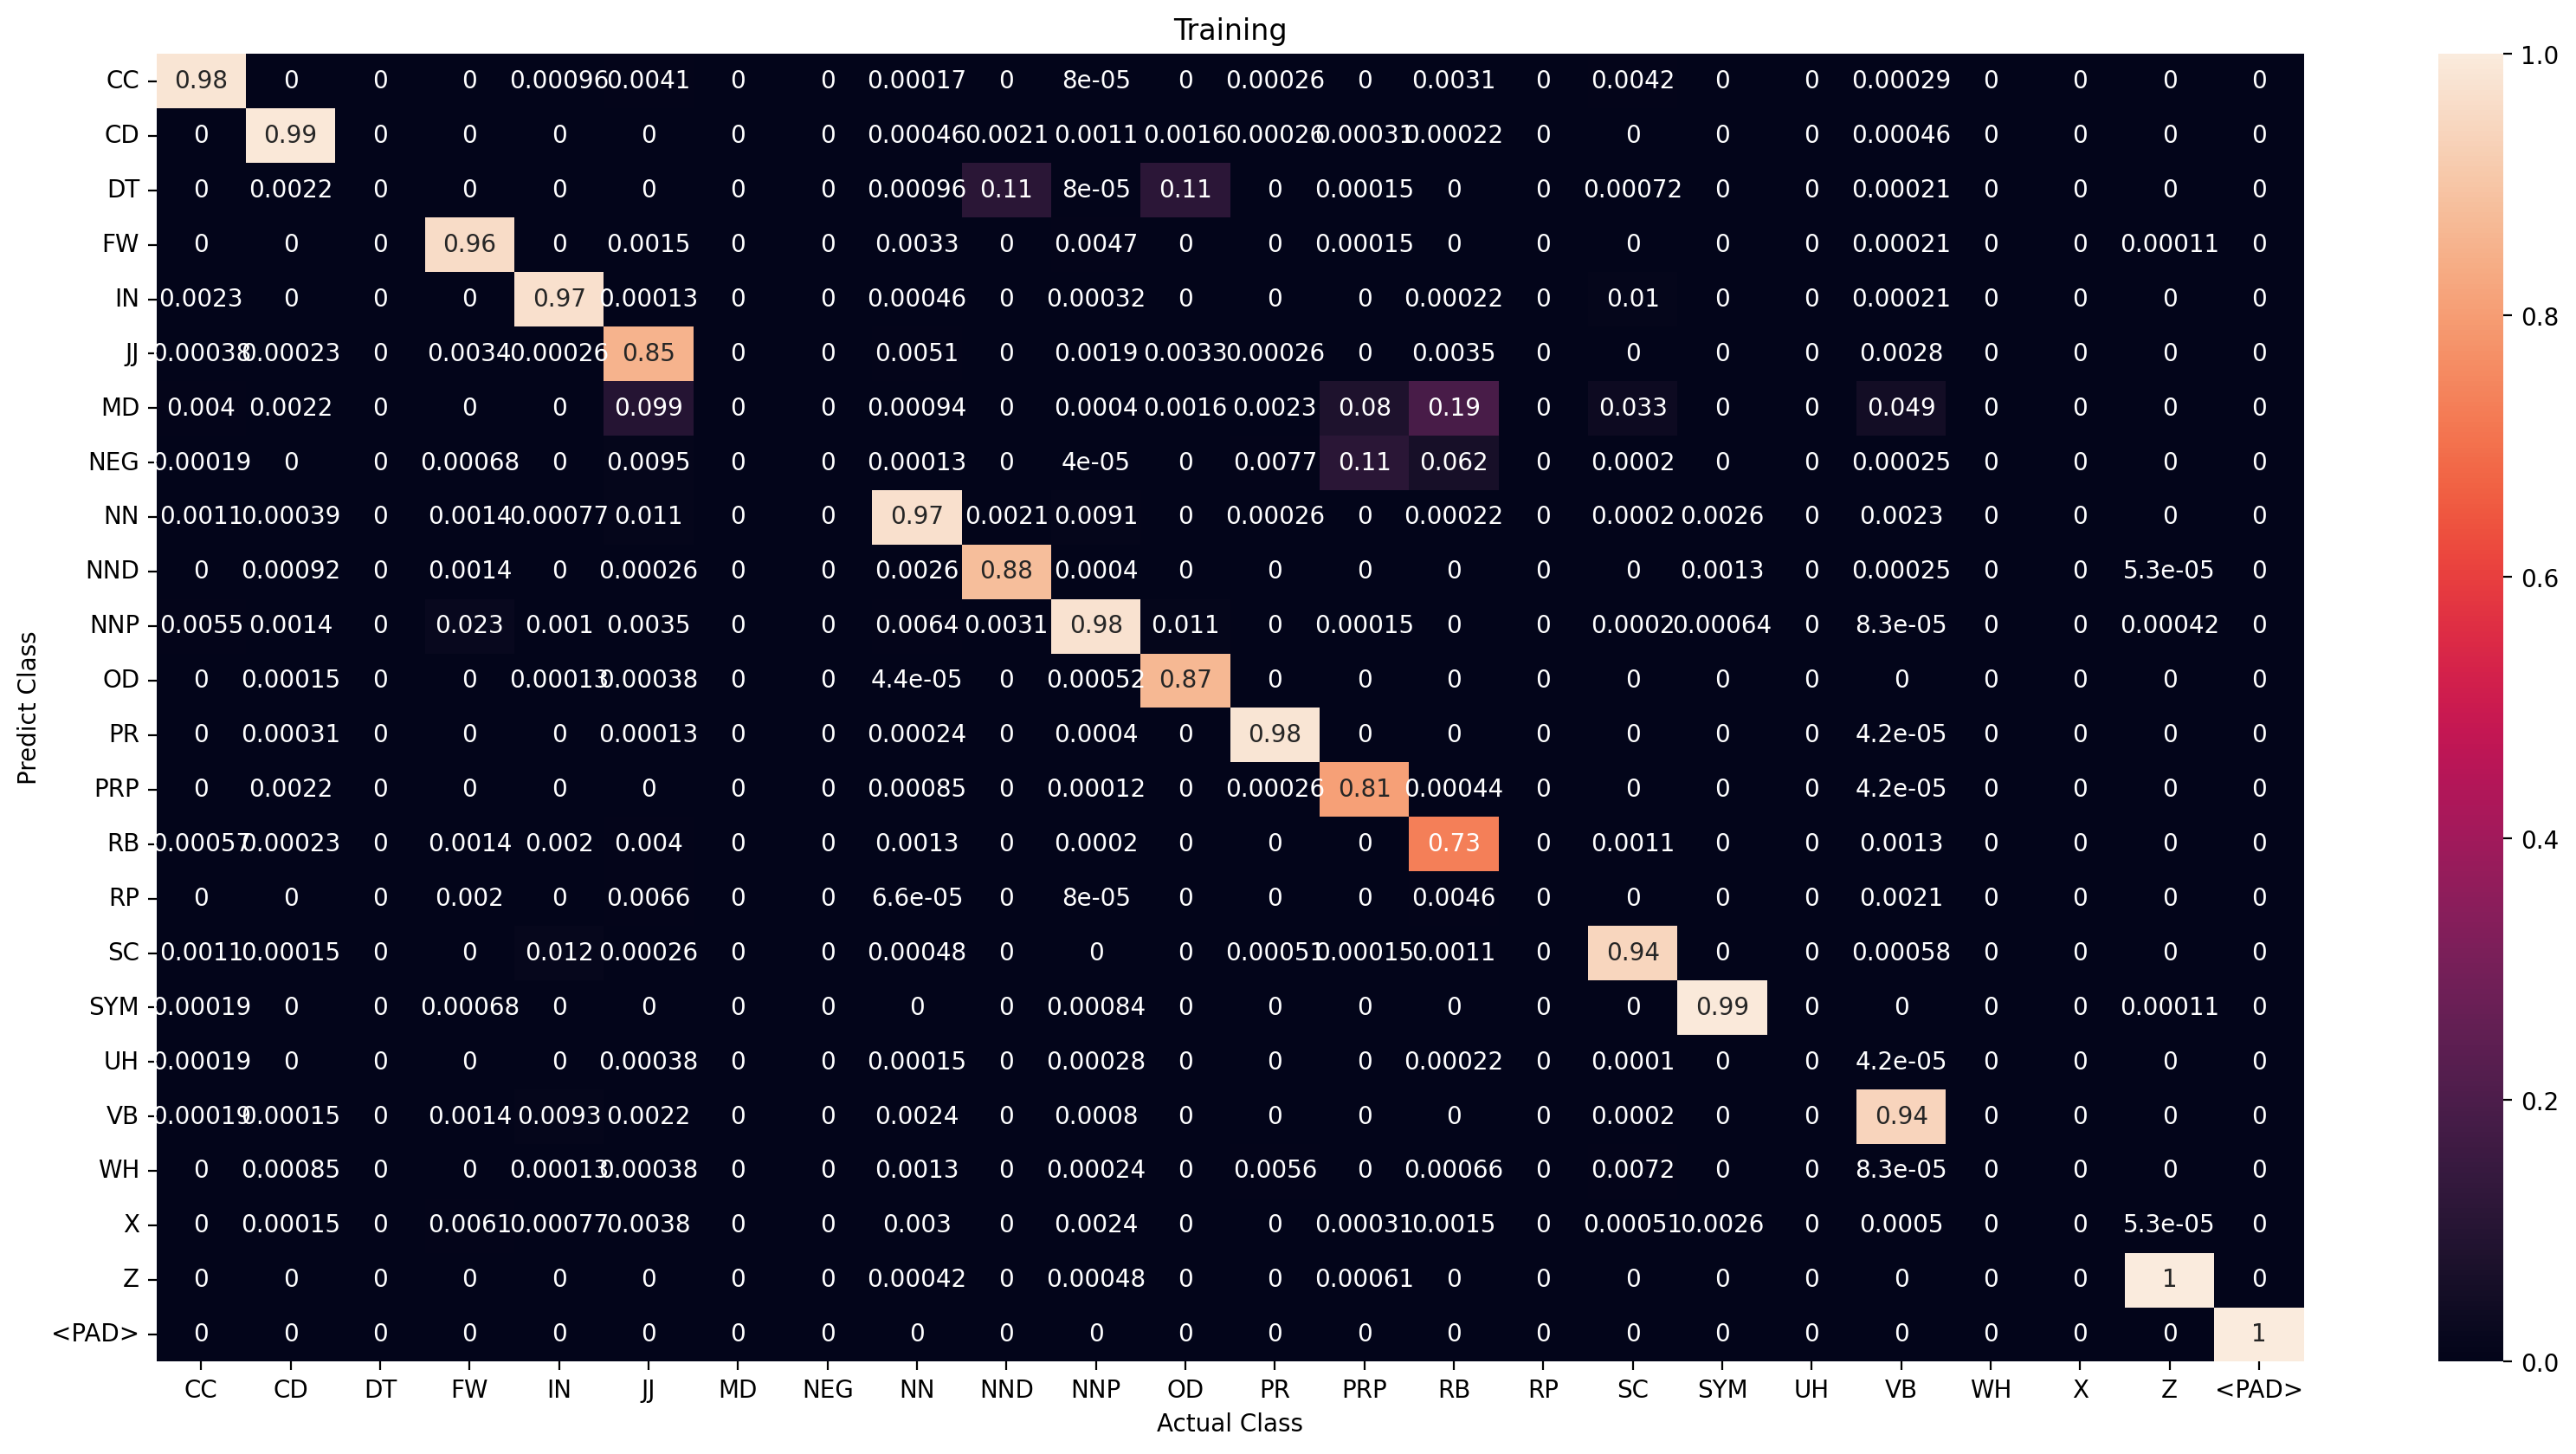

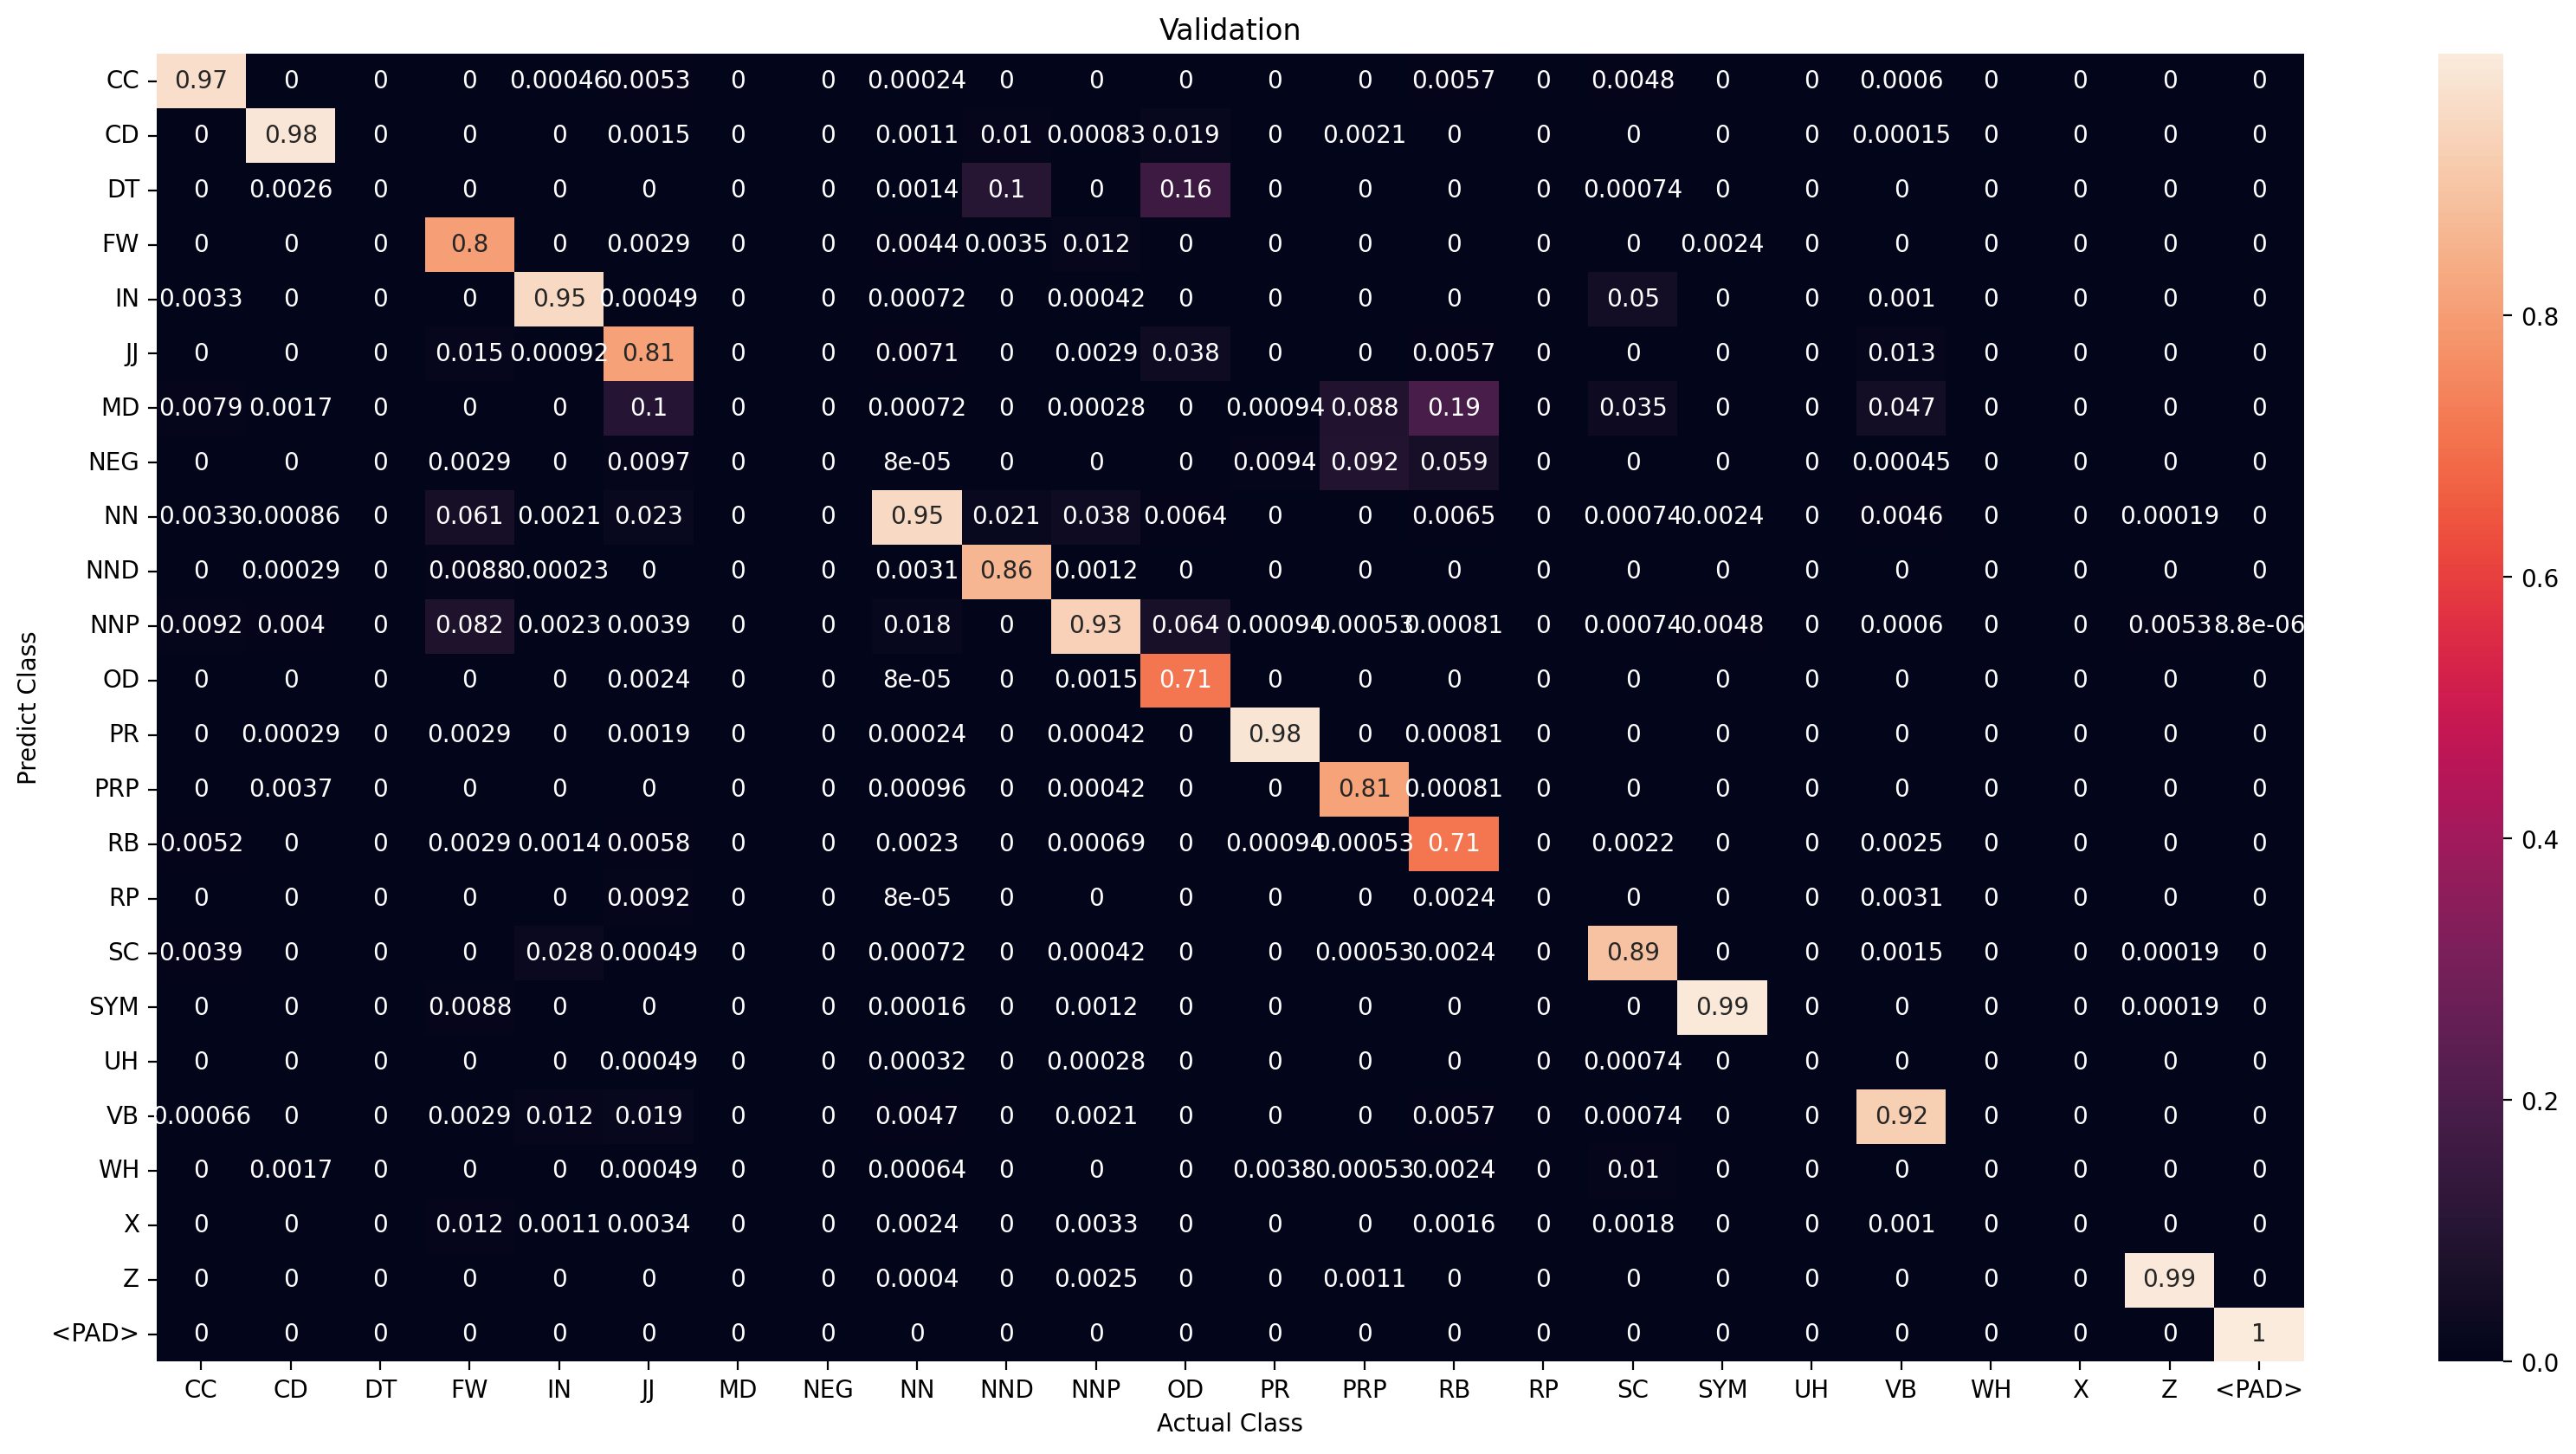

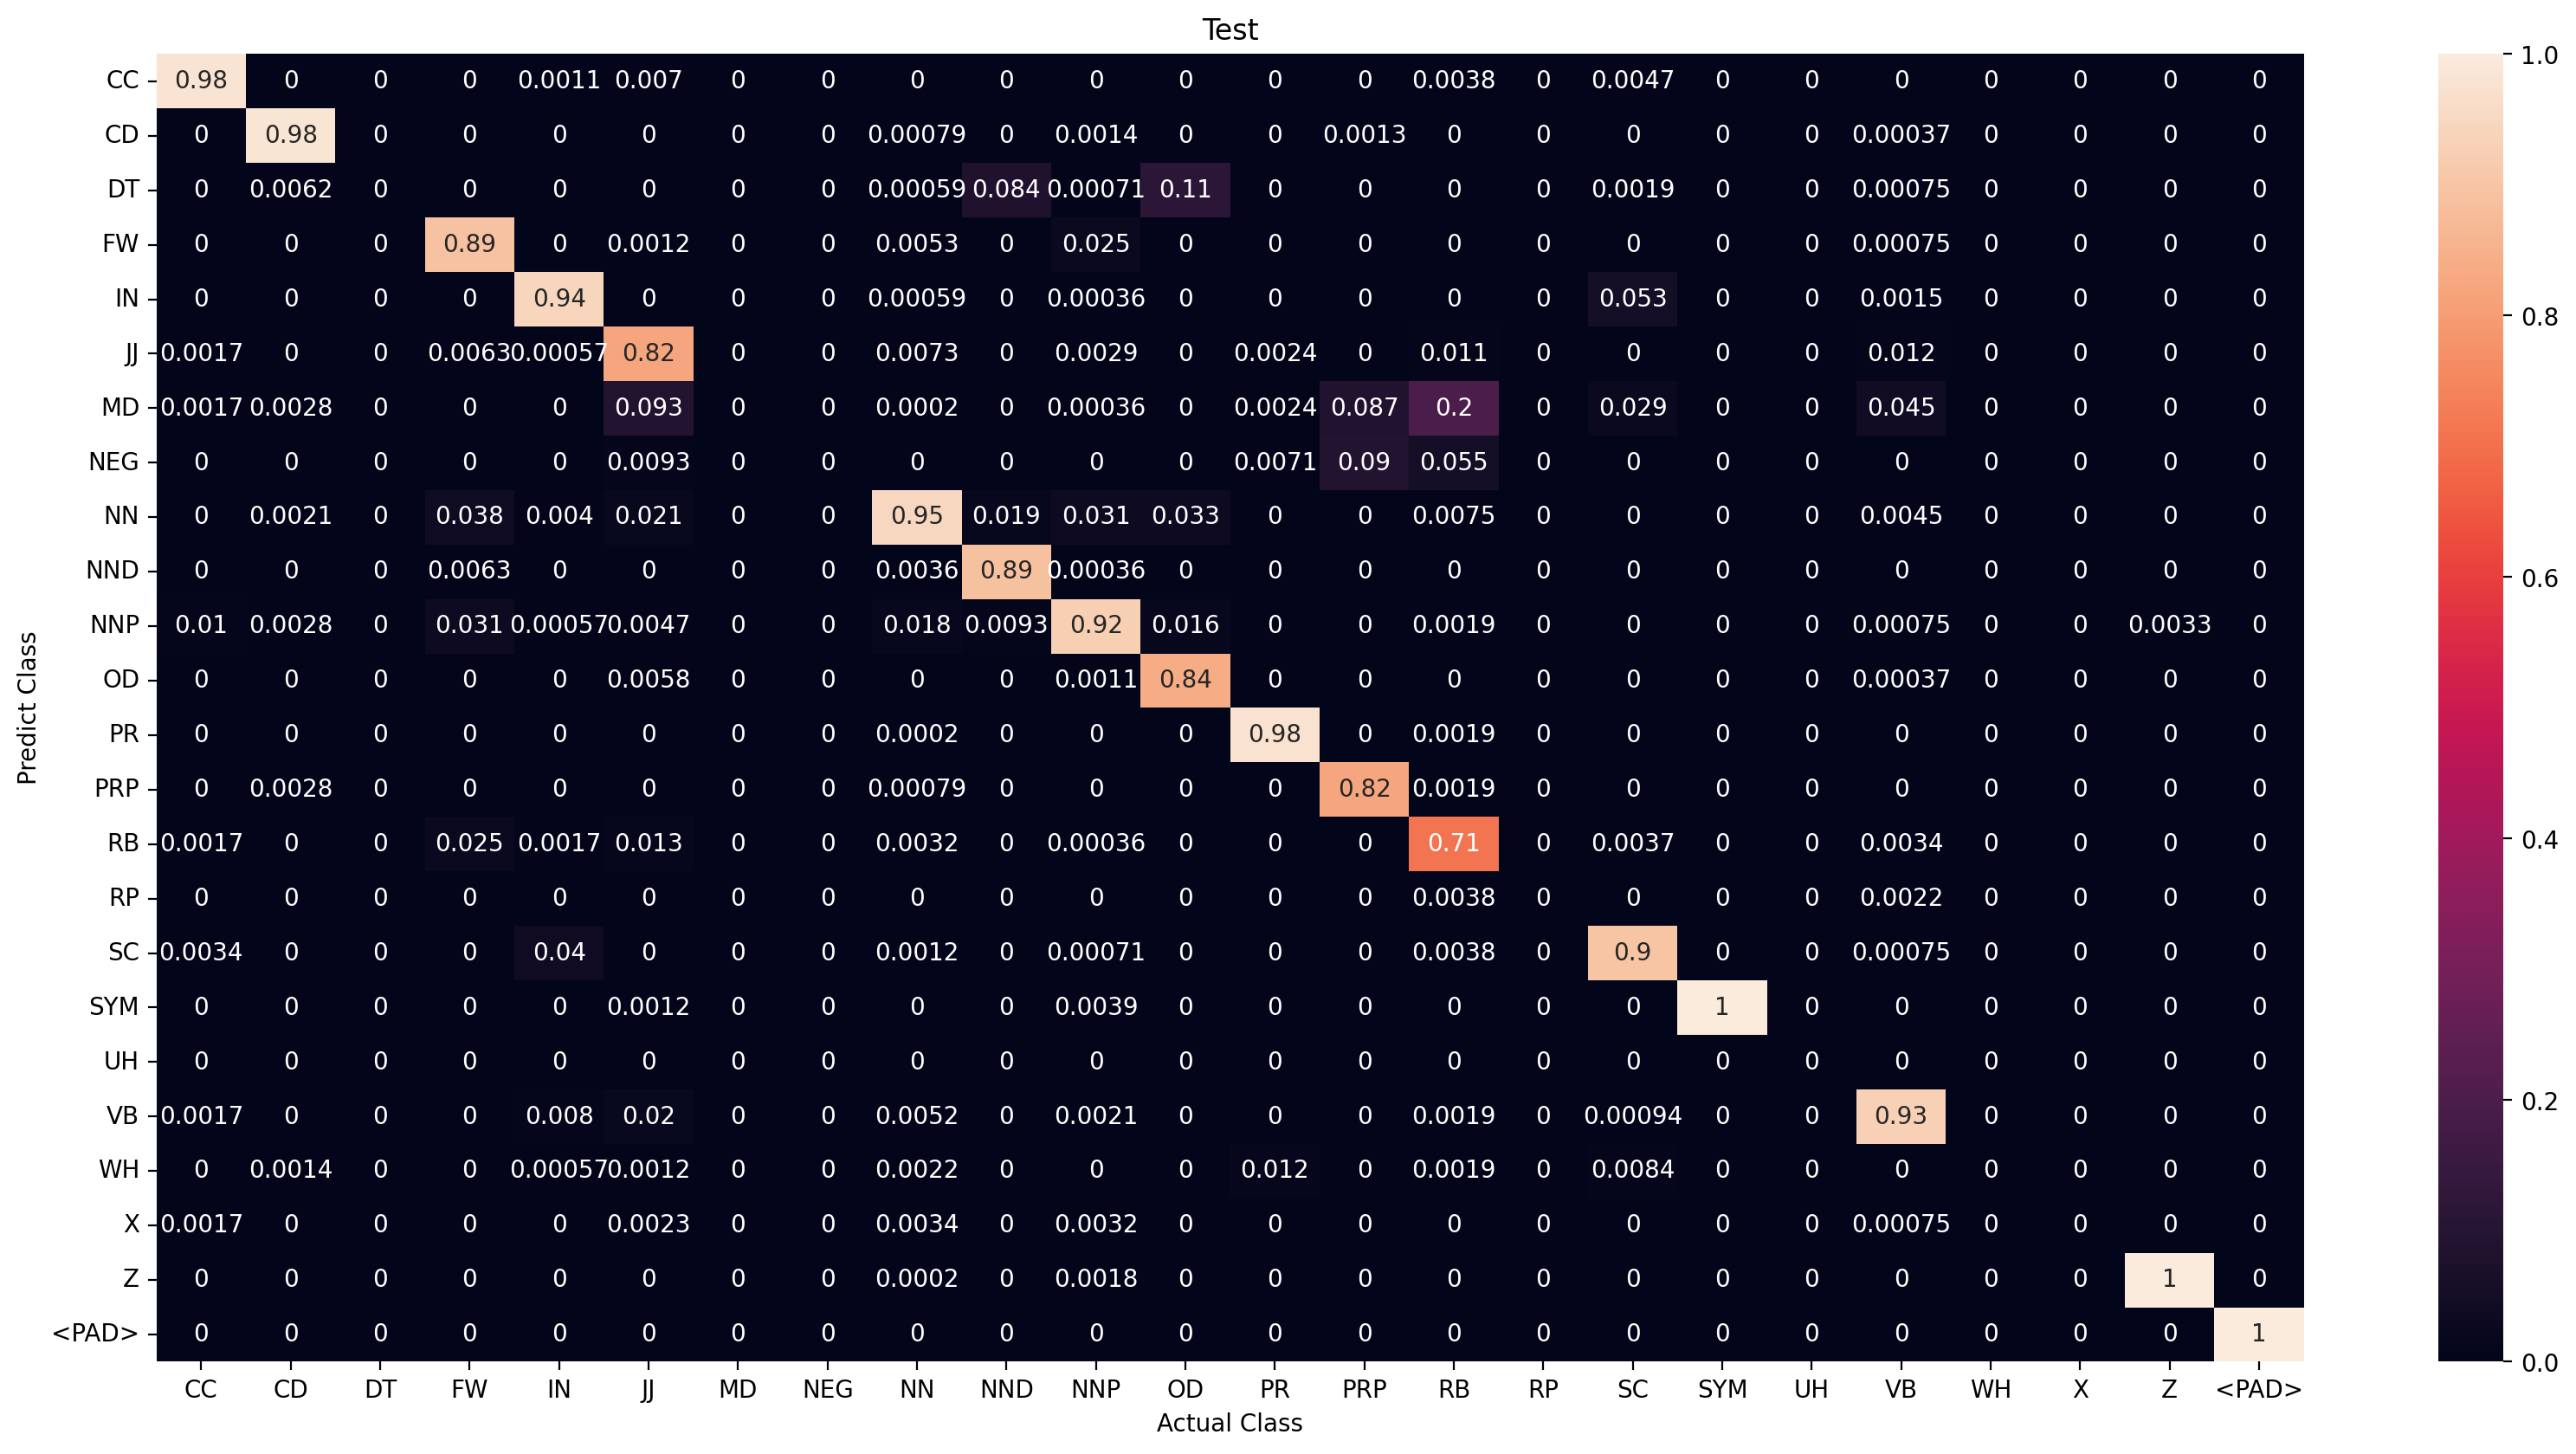

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5336   | CC    : 5216       | CC    : 120      |
| CD    : 12904  | CD    : 12837      | CD    : 67       |
| DT    : 263    | DT    : 0          | DT    : 263      |
| FW    : 1697   | FW    : 1410       | FW    : 287      |
| IN    : 15290  | IN    : 15141      | IN    : 149      |
| JJ    : 7049   | JJ    : 6667       | JJ    : 382      |
| MD    : 3783   | MD    : 0          | MD    : 3783     |
| NEG   : 1126   | NEG   : 0          | NEG   : 1126     |
| NN    : 44769  | NN    : 44364      | NN    : 405      |
| NND   : 998    | NND   : 842        | NND   : 156      |
| NNP   : 24884  | NNP   : 24445      | NNP   : 439      |
| OD    : 550    | OD    : 528        | OD    : 22       |
| PR    : 3878   | PR    : 3851       | PR    : 27       |
| PRP   : 5355   | PRP   : 5281       | PRP   : 74       |
| RB    : 3517   | RB    : 3341       | RB    : 176      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10, 16, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11934
Correct prediction          : 11224
Wrong prediction            : 710
Percentage correct oov pred : 94.05061169767052

Validation
Number OOV token            : 3261
Correct prediction          : 2947
Wrong prediction            : 314
Percentage correct oov pred : 90.37105182459368

Test
Number OOV token            : 1367
Correct prediction          : 1223
Wrong prediction            : 144
Percentage correct oov pred : 89.4659839063643



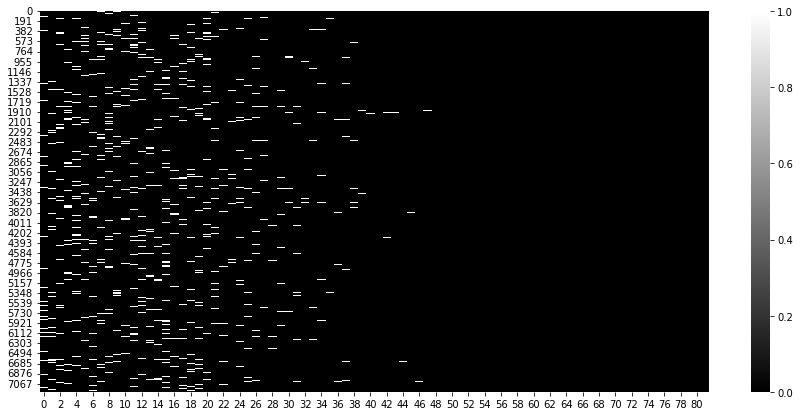

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

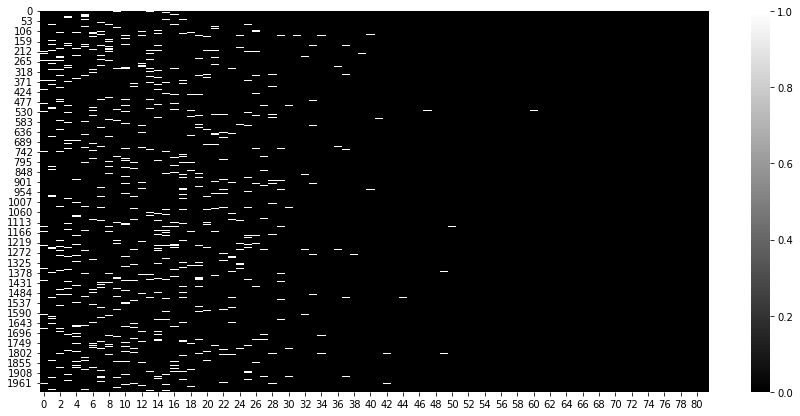

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

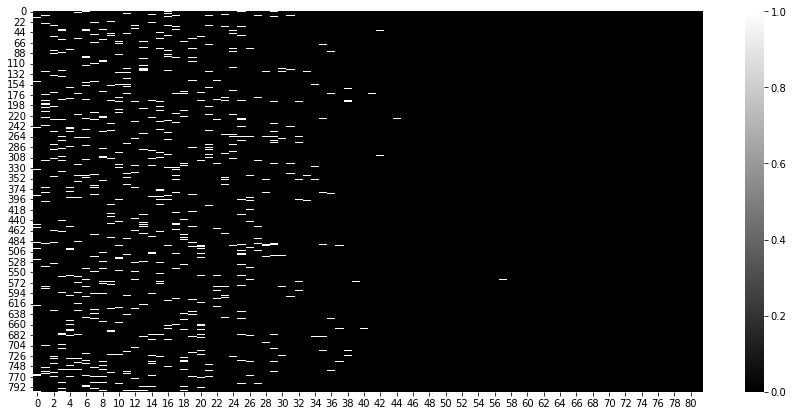

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);